In [ ]:

import os, glob, gc, random
import numpy as np
import cv2
from tqdm.auto import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

d:\Diux\hoctap\DoAn\myvenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:


# ---------------- Config ----------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

TRAIN_DIR = "D:\Diux\hoctap\DoAn\ddr\train_preprocess"   
VAL_DIR   = "D:\Diux\hoctap\DoAn\ddr\val_preprocess"     
IMG_SIZE  = 224
BATCH_SIZE = 16
N_CLASSES = 5


DO_CROP     = False   # True để dùng crop_image_from_gray
DO_CONTRAST = False   # True để dùng cv2.addWeighted + GaussianBlur
DO_AUGMENT  = False   # True để dùng AUGMENT_TRAIN

LOCAL_RESNET50_NOTOP = "D:\Diux\hoctap\DoAn\models\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
# để None sẽ dùng weights="imagenet"

# ---------------- GPU memory growth ----------------
gpus = tf.config.experimental.list_physical_devices('GPU')
for g in gpus:
    try: tf.config.experimental.set_memory_growth(g, True)
    except: pass

# ---------------- Utils: scan files ----------------
def list_files_and_labels(root_dir):
    fns, labels = [], []
    for cls in ["0","1","2","3","4"]:
        cls_dir = os.path.join(root_dir, cls)
        paths = glob.glob(os.path.join(cls_dir, "*.jpg")) + glob.glob(os.path.join(cls_dir, "*.JPG"))
        fns.extend(paths)
        labels.extend([int(cls)] * len(paths))
    # shuffle ổn định
    idx = np.arange(len(fns))
    rng = np.random.default_rng(SEED); rng.shuffle(idx)
    fns    = [fns[i] for i in idx]
    labels = np.array([labels[i] for i in idx], dtype=np.int32)
    return fns, labels

X_train_fns, y_train_labels = list_files_and_labels(TRAIN_DIR)
X_val_fns,   y_val_labels   = list_files_and_labels(VAL_DIR)
print("Train counts:", {i:int((y_train_labels==i).sum()) for i in range(N_CLASSES)})
print("Val counts  :", {i:int((y_val_labels==i).sum()) for i in range(N_CLASSES)})

# ---------------- Augment  ----------------
AUGMENT_TRAIN = None
def aug_img(augment, img_rgb):

    return img_rgb

if DO_AUGMENT:
    try:
        import albumentations as A
        AUGMENT_TRAIN = A.Compose([
            A.RandomResizedCrop(height=IMG_SIZE, width=IMG_SIZE, scale=(0.8, 1.0), ratio=(0.9, 1.1), p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.2),
            A.Rotate(limit=20, p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=0, p=0.5),
            A.RandomBrightnessContrast(0.15, 0.15, p=0.5),
            A.HueSaturationValue(10, 20, 10, p=0.4),
        ], p=1.0)
        def aug_img(augment, img_rgb):
            return augment(image=img_rgb)["image"]
    except Exception as e:
        print("Albumentations chưa sẵn sàng, tắt augment. Lý do:", e)
        DO_AUGMENT = False
        AUGMENT_TRAIN = None

# ---------------- Crop theo hướng dẫn gốc (có thể tắt qua DO_CROP) ----------------
def crop_image_from_gray(img, tol=7):
    if img.ndim == 2:
        mask = img > tol
        if mask.any():
            x, y = np.where(mask)
            img = img[np.min(x):np.max(x)+1, np.min(y):np.max(y)+1]
        return img
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = gray > tol
    if mask.any():
        x, y = np.where(mask)
        img = img[np.min(x):np.max(x)+1, np.min(y):np.max(y)+1, :]
    return img

# ---------------- ImageDataGenerator (streaming, theo hướng dẫn) ----------------
class ImageDataGenerator(keras.utils.Sequence):
    def __init__(self,
                 train_fns,
                 labels,
                 augment=None,
                 batch_size=32,
                 img_size=224,
                 n_channels=3,
                 sigmaX=10,
                 normalize="normal",
                 add_mixup=False,
                 shuffle=False,
                 to_gray=False,
                 add_contrast=True,
                 add_crop=True,
                 return_label=True):
        self.batch_size = batch_size
        self.train_fns = train_fns
        self.labels = labels
        self.img_indexes = range(len(self.train_fns))

        self.img_size = img_size
        self.n_channels = 1 if to_gray else n_channels
        self.to_gray = to_gray
        self.shuffle = shuffle
        self.normalize = normalize
        self.augment = augment
        self.return_label = return_label
        self.add_contrast = add_contrast
        self.add_crop = add_crop
        self.add_mixup = add_mixup
        self.sigmaX = sigmaX

        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.train_fns) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        temp_img_indexes = [self.img_indexes[i] for i in indexes]
        if self.return_label:
            X, y = self.__data_generation(temp_img_indexes)
            return X, y
        else:
            return self.__data_generation(temp_img_indexes)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.train_fns))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def normalize_img(self, img):
        img = img.astype(np.float32)
        mean, std = np.mean(img), np.std(img)
        return (img - mean) / std if std > 0 else img * 0.

    def __data_generation(self, img_indexes):
        X = np.empty((self.batch_size, self.img_size, self.img_size, self.n_channels), dtype=np.float32)
        y = np.empty((self.batch_size,), dtype=int)

        for index, img_index in enumerate(img_indexes):
            img = cv2.imread(self.train_fns[img_index])                    # BGR
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)                     # -> RGB

            # crop nếu bật
            if self.add_crop:
                img = crop_image_from_gray(img)

            # augment nếu bật
            if self.augment is not None:
                img = aug_img(self.augment, img)

         
            img = cv2.resize(img, (self.img_size, self.img_size))

            # nếu bật
            if self.add_contrast:
                img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), self.sigmaX), -4, 128)

            if self.to_gray:
                img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

            if self.normalize == "normal":
                img = img / 255.0
            elif self.normalize == "mean":
                img = self.normalize_img(img)

            img = img.astype(np.float32)
            if self.to_gray and len(img.shape) != 3:
                img = np.expand_dims(img, axis=-1)

            X[index] = img
            y[index] = self.labels[img_index]

        # one-hot 5 lớp  chuyển sang cumulative (ordinal)
        y = to_categorical(y, num_classes=N_CLASSES)     # ví dụ class 3: [0,0,0,1,0]
        for sub_y in y:
            index_1 = int(np.argmax(sub_y))
            for sub_index in range(index_1):
                sub_y[sub_index] = 1                     # -> [1,1,1,1,0] cho lớp 4
        y = y.astype('float32') 
        return X, y


# ---------------- Callbacks  ----------------
checkpoint = ModelCheckpoint("mode_resnet50_aptos.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=5, verbose=1, restore_best_weights=True)
redonplat = ReduceLROnPlateau(monitor="val_loss", factor=0.5, mode="min", patience=3, verbose=2)
csv_logger = CSVLogger('log_training.csv', append=False, separator=',')

callbacks_list = [checkpoint, early, redonplat, csv_logger]

# ---------------- Model  ----------------
if LOCAL_RESNET50_NOTOP:
    base = ResNet50(weights=None, include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base.load_weights(LOCAL_RESNET50_NOTOP)
else:
    base = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

def build_model(head_model):
    model = Sequential()
    model.add(head_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    return model

model = build_model(base)

# ---------------- Data generators ----------------
train_gen = ImageDataGenerator(
    X_train_fns, y_train_labels,
    n_channels=3, img_size=IMG_SIZE, batch_size=BATCH_SIZE, normalize="normal",
    add_contrast=DO_CONTRAST, to_gray=False, shuffle=False, add_crop=DO_CROP, augment=AUGMENT_TRAIN
)
val_gen = ImageDataGenerator(
    X_val_fns, y_val_labels,
    n_channels=3, img_size=IMG_SIZE, batch_size=BATCH_SIZE, normalize="normal",
    add_contrast=DO_CONTRAST, to_gray=False, shuffle=False, add_crop=DO_CROP, augment=None
)

# ---------------- Class weights ----------------
from sklearn.utils import class_weight
class_weight_ = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
# ---------------- F1 metric ----------------
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        return true_positives / (possible_positives + K.epsilon())

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        return true_positives / (predicted_positives + K.epsilon())

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*((p*r)/(p+r+K.epsilon()))
# ---------------- Warm-up (freeze gần hết, train head 1 epochs) ----------------
for layer in model.layers:
    layer.trainable = False
for i in range(-3, 0):  # GAP, Dropout, Dense
    model.layers[i].trainable = True

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-2), metrics=['accuracy', f1])





<>:5: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:16: SyntaxWarning: invalid escape sequence '\D'
<>:5: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:16: SyntaxWarning: invalid escape sequence '\D'
C:\Users\tran1\AppData\Local\Temp\ipykernel_9168\2742576099.py:5: SyntaxWarning: invalid escape sequence '\D'
  TRAIN_DIR = "D:\Diux\hoctap\DoAn\ddr\train_preprocess"   # .../train/0..4/*.jpg
C:\Users\tran1\AppData\Local\Temp\ipykernel_9168\2742576099.py:6: SyntaxWarning: invalid escape sequence '\D'
  VAL_DIR   = "D:\Diux\hoctap\DoAn\ddr\val_preprocess"     # .../val/0..4/*.jpg
C:\Users\tran1\AppData\Local\Temp\ipykernel_9168\2742576099.py:16: SyntaxWarning: invalid escape sequence '\D'
  LOCAL_RESNET50_NOTOP = "D:\Diux\hoctap\DoAn\models\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"


Train counts: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
Val counts  : {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}


C:\Users\tran1\AppData\Local\Temp\ipykernel_9168\2742576099.py:5: SyntaxWarning: invalid escape sequence '\D'
  TRAIN_DIR = "D:\Diux\hoctap\DoAn\ddr\train_preprocess"   # .../train/0..4/*.jpg
C:\Users\tran1\AppData\Local\Temp\ipykernel_9168\2742576099.py:6: SyntaxWarning: invalid escape sequence '\D'
  VAL_DIR   = "D:\Diux\hoctap\DoAn\ddr\val_preprocess"     # .../val/0..4/*.jpg
C:\Users\tran1\AppData\Local\Temp\ipykernel_9168\2742576099.py:16: SyntaxWarning: invalid escape sequence '\D'
  LOCAL_RESNET50_NOTOP = "D:\Diux\hoctap\DoAn\models\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"


OSError: [Errno 22] Unable to synchronously open file (unable to open file: name = 'D:\Diux\hoctap\DoAn\modelsesnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', errno = 22, error message = 'Invalid argument', flags = 0, o_flags = 0)

In [ ]:

history_warm = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=1,  
    validation_data=val_gen,
    validation_steps=len(val_gen),
    callbacks=callbacks_list,
    # class_weight=class_weight_
)

# ---------------- Fine-tune all (unfreeze, LR nhỏ) ----------------
for layer in model.layers:
    layer.trainable = True

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy', f1])

history_ft = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=10,
    validation_data=val_gen,
    validation_steps=len(val_gen),
    callbacks=callbacks_list,
    # class_weight=class_weight_
)

/home/duc/Documents/DoAn/myvenv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9725 - f1: 0.7953 - loss: 0.4767

2025-08-16 01:26:26.772041: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1729', 76 bytes spill stores, 76 bytes spill loads

2025-08-16 01:26:27.197872: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1729', 3816 bytes spill stores, 3796 bytes spill loads




Epoch 1: val_loss improved from inf to 0.48914, saving model to mode_resnet50_aptos.keras
457/457 ━━━━━━━━━━━━━━━━━━━━ 35s 61ms/step - accuracy: 0.9726 - f1: 0.7953 - loss: 0.4766 - val_accuracy: 1.0000 - val_f1: 0.8001 - val_loss: 0.4891 - learning_rate: 0.0100
Restoring model weights from the end of the best epoch: 1.
Epoch 1/10


2025-08-16 01:27:10.337456: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:382] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.7193 - f1: 0.8658 - loss: 0.8914
Epoch 1: val_loss did not improve from 0.48914
457/457 ━━━━━━━━━━━━━━━━━━━━ 123s 182ms/step - accuracy: 0.7193 - f1: 0.8658 - loss: 0.8905 - val_accuracy: 1.0000 - val_f1: 0.7218 - val_loss: 1.0433 - learning_rate: 1.0000e-04
Epoch 2/10
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.7621 - f1: 0.9236 - loss: 0.2044
Epoch 2: val_loss improved from 0.48914 to 0.23830, saving model to mode_resnet50_aptos.keras
457/457 ━━━━━━━━━━━━━━━━━━━━ 82s 180ms/step - accuracy: 0.7622 - f1: 0.9236 - loss: 0.2044 - val_accuracy: 0.9432 - val_f1: 0.8975 - val_loss: 0.2383 - learning_rate: 1.0000e-04
Epoch 3/10
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.7368 - f1: 0.9535 - loss: 0.1317
Epoch 3: val_loss did not improve from 0.23830
457/457 ━━━━━━━━━━━━━━━━━━━━ 81s 177ms/step - accuracy: 0.7369 - f1: 0.9535 - loss: 0.1317 - val_accuracy: 0.8693 - val_f1: 0.9190 - val_loss: 0.2998 - learning_ra

In [ ]:
# ---------------- Predict trên tập validation  ----------------
def process_img(fn_path, img_size=512):
    img = cv2.imread(fn_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if DO_CROP:
        img = crop_image_from_gray(img)
    img = cv2.resize(img, (img_size, img_size))
    if DO_CONTRAST:
        img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), 10), -4, 128)
    img = img / 255.0
    return img.astype(np.float32)

y_pred_val = []
for val_path in tqdm(X_val_fns, desc="Predict val"):
    p_img = process_img(val_path, img_size=IMG_SIZE)    
    sub_y_pred = model.predict(np.expand_dims(p_img, axis=0), verbose=0)
    sub_y_pred = (sub_y_pred > 0.50).astype(int)
    sub_y_pred = sub_y_pred.sum(axis=1) - 1
    y_pred_val.append(int(sub_y_pred[0]))

gc.collect()


Predict val: 100%|██████████| 3511/3511 [04:04<00:00, 14.35it/s]


22775

In [ ]:
p_img_t = process_img("/home/duc/Documents/DoAn/eyepacs_2015/test_preprocess_ben_graham/1/178_right.jpg", img_size=IMG_SIZE)     
sub_y_pred_t = model.predict(np.expand_dims(p_img, axis=0), verbose=0)
print(sub_y_pred_t)
sub_y_pred_t = (sub_y_pred_t > 0.50).astype(int)
print(sub_y_pred_t)
sub_y_pred_t = sub_y_pred_t.sum(axis=1) - 1
print(sub_y_pred_t)



[[0.9999999  0.96037805 0.12984692 0.00875008 0.00751837]]
[[1 1 0 0 0]]
[1]


In [ ]:
model = tf.keras.models.load_model(
    "mode_resnet50_aptos.keras",
    compile=False,   
    custom_objects={'f1': f1}  
)


<>:16: SyntaxWarning: invalid escape sequence '\D'
<>:16: SyntaxWarning: invalid escape sequence '\D'
C:\Users\tran1\AppData\Local\Temp\ipykernel_9168\2593577995.py:16: SyntaxWarning: invalid escape sequence '\D'
  "D:\Diux\hoctap\DoAn\models\mode_resnet50.keras",


Test counts: {0: 1444, 1: 1480, 2: 1598, 3: 1386, 4: 1416}
Accuracy : 0.4025
Precision: 0.4397
Recall   : 0.4025
F1-score : 0.3841

Detailed report:
               precision    recall  f1-score   support

           0     0.9539    0.7452    0.8367      1444
           1     0.3200    0.0595    0.1003      1480
           2     0.2322    0.1289    0.1658      1598
           3     0.2250    0.5390    0.3175      1386
           4     0.4848    0.5869    0.5310      1416

    accuracy                         0.4025      7324
   macro avg     0.4432    0.4119    0.3902      7324
weighted avg     0.4397    0.4025    0.3841      7324



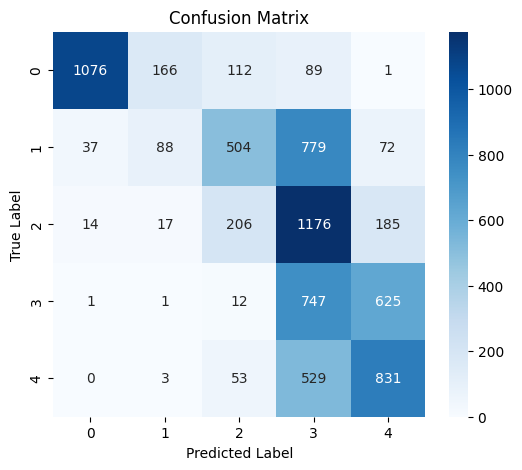

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ---------------- Load test set ----------------
TEST_DIR = "/home/duc/Documents/DoAn/aptos2019-blindness-detection/train_preprocess"  
X_test_fns, y_test_labels = list_files_and_labels(TEST_DIR)
print("Test counts:", {i:int((y_test_labels==i).sum()) for i in range(N_CLASSES)})

# ---------------- Predict on test set ----------------
def process_img(fn_path, img_size=IMG_SIZE):
    img = cv2.imread(fn_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if DO_CROP:
        img = crop_image_from_gray(img)
    img = cv2.resize(img, (img_size, img_size))
    if DO_CONTRAST:
        img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), 10), -4, 128)
    img = img / 255.0
    return img.astype(np.float32)

def cumulative_to_label(p, thr=0.5):
    return (p > thr).sum(axis=1) - 1

y_pred_test = []
for path in X_test_fns:
    img = process_img(path)
    pred = model.predict(np.expand_dims(img, axis=0), verbose=0)
    label = cumulative_to_label(pred, 0.5)[0]
    y_pred_test.append(label)

y_pred_test = np.array(y_pred_test)

# ---------------- Evaluation metrics ----------------
acc  = accuracy_score(y_test_labels, y_pred_test)
prec = precision_score(y_test_labels, y_pred_test, average='weighted', zero_division=0)
rec  = recall_score(y_test_labels, y_pred_test, average='weighted', zero_division=0)
f1s  = f1_score(y_test_labels, y_pred_test, average='weighted', zero_division=0)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1s:.4f}")
print("\nDetailed report:\n", classification_report(y_test_labels, y_pred_test, digits=4))

# ---------------- Confusion Matrix ----------------
cm = confusion_matrix(y_test_labels, y_pred_test, labels=range(N_CLASSES))
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(i) for i in range(N_CLASSES)],
            yticklabels=[str(i) for i in range(N_CLASSES)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Test counts: {0: 181, 1: 37, 2: 100, 3: 19, 4: 30}
Accuracy : 0.6594
Precision: 0.7007
Recall   : 0.6594
F1-score : 0.6683

Detailed report:
               precision    recall  f1-score   support

           0     0.8989    0.9337    0.9160       181
           1     0.3947    0.4054    0.4000        37
           2     0.6769    0.4400    0.5333       100
           3     0.1404    0.4211    0.2105        19
           4     0.3158    0.2000    0.2449        30

    accuracy                         0.6594       367
   macro avg     0.4853    0.4800    0.4609       367
weighted avg     0.7007    0.6594    0.6683       367



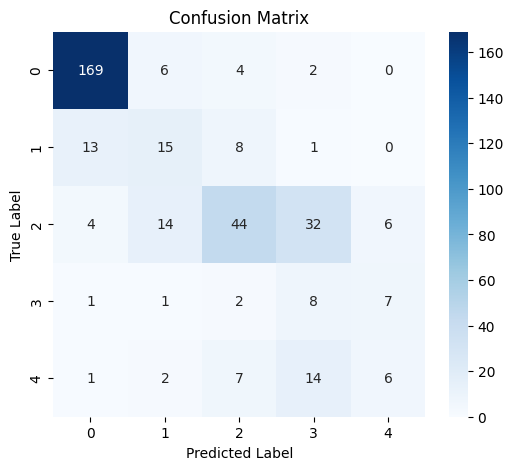

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ---------------- Load test set ----------------
TEST_DIR = "/home/duc/Documents/DoAn/aptos2019-blindness-detection/test_preprocess" 
X_test_fns, y_test_labels = list_files_and_labels(TEST_DIR)
print("Test counts:", {i:int((y_test_labels==i).sum()) for i in range(N_CLASSES)})

# ---------------- Predict on test set ----------------
def process_img(fn_path, img_size=IMG_SIZE):
    img = cv2.imread(fn_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if DO_CROP:
        img = crop_image_from_gray(img)
    img = cv2.resize(img, (img_size, img_size))
    if DO_CONTRAST:
        img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), 10), -4, 128)
    img = img / 255.0
    return img.astype(np.float32)

def cumulative_to_label(p, thr=0.5):
    return (p > thr).sum(axis=1) - 1

y_pred_test = []
for path in X_test_fns:
    img = process_img(path)
    pred = model.predict(np.expand_dims(img, axis=0), verbose=0)
    label = cumulative_to_label(pred, 0.5)[0]
    y_pred_test.append(label)

y_pred_test = np.array(y_pred_test)

# ---------------- Evaluation metrics ----------------
acc  = accuracy_score(y_test_labels, y_pred_test)
prec = precision_score(y_test_labels, y_pred_test, average='weighted', zero_division=0)
rec  = recall_score(y_test_labels, y_pred_test, average='weighted', zero_division=0)
f1s  = f1_score(y_test_labels, y_pred_test, average='weighted', zero_division=0)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1s:.4f}")
print("\nDetailed report:\n", classification_report(y_test_labels, y_pred_test, digits=4))

# ---------------- Confusion Matrix ----------------
cm = confusion_matrix(y_test_labels, y_pred_test, labels=range(N_CLASSES))
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(i) for i in range(N_CLASSES)],
            yticklabels=[str(i) for i in range(N_CLASSES)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

<>:7: SyntaxWarning: invalid escape sequence '\D'
<>:7: SyntaxWarning: invalid escape sequence '\D'
C:\Users\tran1\AppData\Local\Temp\ipykernel_9168\3366473489.py:7: SyntaxWarning: invalid escape sequence '\D'
  TEST_DIR = "D:\Diux\hoctap\DoAn\ddr\\test_preprocess"  # .../test/0..4/*.jpg


Test counts: {0: 1254, 1: 126, 2: 896, 3: 48, 4: 182}
Accuracy : 0.7095
Precision: 0.8034
Recall   : 0.7095
F1-score : 0.7387

Detailed report:
               precision    recall  f1-score   support

           0     0.8491    0.8612    0.8551      1254
           1     0.1262    0.4127    0.1933       126
           2     0.8577    0.5379    0.6612       896
           3     0.2609    0.5000    0.3429        48
           4     0.8333    0.7692    0.8000       182

    accuracy                         0.7095      2506
   macro avg     0.5854    0.6162    0.5705      2506
weighted avg     0.8034    0.7095    0.7387      2506



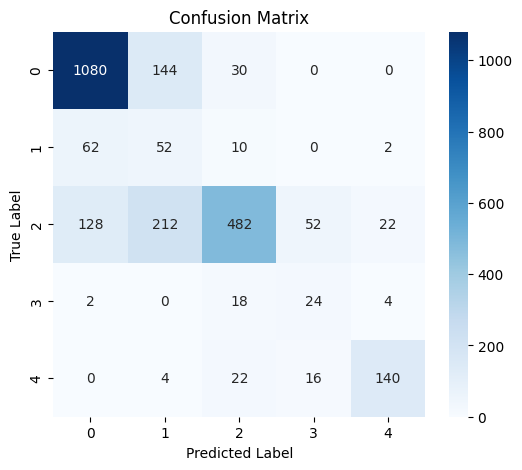

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ---------------- Load test set ----------------
TEST_DIR = "D:\Diux\hoctap\DoAn\ddr\\test_preprocess"  
X_test_fns, y_test_labels = list_files_and_labels(TEST_DIR)
print("Test counts:", {i:int((y_test_labels==i).sum()) for i in range(N_CLASSES)})
IMG_SIZE  = 224
BATCH_SIZE = 16
N_CLASSES = 5
# ---------------- Predict on test set ----------------
def process_img(fn_path, img_size=IMG_SIZE):
    img = cv2.imread(fn_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
   
    img = cv2.resize(img, (img_size, img_size))
    
    img = img / 255.0
    return img.astype(np.float32)

def cumulative_to_label(p, thr=0.5):
    return (p > thr).sum(axis=1) - 1

y_pred_test = []
for path in X_test_fns:
    img = process_img(path)
    pred = model.predict(np.expand_dims(img, axis=0), verbose=0)
    label = cumulative_to_label(pred, 0.5)[0]
    y_pred_test.append(label)

y_pred_test = np.array(y_pred_test)

# ---------------- Evaluation metrics ----------------
acc  = accuracy_score(y_test_labels, y_pred_test)
prec = precision_score(y_test_labels, y_pred_test, average='weighted', zero_division=0)
rec  = recall_score(y_test_labels, y_pred_test, average='weighted', zero_division=0)
f1s  = f1_score(y_test_labels, y_pred_test, average='weighted', zero_division=0)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1s:.4f}")
print("\nDetailed report:\n", classification_report(y_test_labels, y_pred_test, digits=4))

# ---------------- Confusion Matrix ----------------
cm = confusion_matrix(y_test_labels, y_pred_test, labels=range(N_CLASSES))
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(i) for i in range(N_CLASSES)],
            yticklabels=[str(i) for i in range(N_CLASSES)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [1]:
!ipynb-py-convert structure_model_resnet50_eyepacs2015.ipynb structure_model_resnet50_eyepacs2015.py